In [15]:
import pandas as pd
import numpy as np
# from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import joblib

In [2]:
"""
iris = load_iris(as_frame = True)
# data_dict.keys()
features, targets = iris['data'], iris["target"]
print(features.info())
"""

'\niris = load_iris(as_frame = True)\n# data_dict.keys()\nfeatures, targets = iris[\'data\'], iris["target"]\nprint(features.info())\n'

# Pre-Processing

In [3]:
data = pd.read_csv("./datasets/galapagos.csv")

features = data.drop(columns = ["Date", "Bleaching_Alert_Area"])
targets = data["Bleaching_Alert_Area"]

f_train, f_test, t_train, t_test = train_test_split(
    features,
    targets,
    test_size = 0.4,
    random_state = 42
)

# Initialize Pipeline

Create a `pipeline` that automatically scales features fed to the model. This avoids data leakage, and packages everything nicely.

In [4]:
pipeline = make_pipeline(
    StandardScaler(),
    SVC(probability = True)
)

# Cross-Validated Hyperparameter Tuning

Use a grid search to find the best possible parameter values for training the model.

In [5]:
params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1],
    'svc__kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(pipeline, params, cv = 3)
grid_search.fit(f_train, t_train)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': [0.001, 0.01, ...], 'svc__kernel': ['rbf', 'linear']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [6]:
best_model = grid_search.best_estimator_
test_score = best_model.score(f_test, t_test)

In [7]:
predictions = best_model.predict(f_test)

# Model Evaluation

## Accuracy

In [8]:
predictions = best_model.predict(f_test)

# prediction accuracy
# np.array( (predictions == t_test), dtype = np.bool).sum() / len(equalities)
accuracy = accuracy_score(t_test, predictions)
print("-" * 30)
print(f"Accuracy: {accuracy:.4f}\n")

# class report
print("-" * 30)
print("Classification Report:")
print(classification_report(t_test, predictions))

# confusion matrix
print("-" * 30)
print("Confusion Matrix:")
print(confusion_matrix(t_test, predictions))

------------------------------
Accuracy: 0.9141

------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4156
           1       0.78      0.53      0.63       741
           2       0.94      0.80      0.87       350
           3       0.91      0.76      0.83       194
           4       0.93      0.93      0.93       427

    accuracy                           0.91      5868
   macro avg       0.90      0.80      0.84      5868
weighted avg       0.91      0.91      0.91      5868

------------------------------
Confusion Matrix:
[[4147    8    0    0    1]
 [ 297  391   18   10   25]
 [  14   51  281    4    0]
 [  11   32    0  147    4]
 [  11   18    0    0  398]]


## ROC Curve, AUC For Multi-Class (One-vs-Rest)

Evaluate how the model differentiates classes based on probability distributions, independent of a fixed threshold.

In [13]:
# -----------------------------------------------------------------------------
# binarize test labels for OvR metrics
classes = np.unique(targets)
t_test_bin = label_binarize(t_test, classes = classes)

# get probability estimates
## (shape: [n_samples, n_classes])
t_score = best_model.predict_proba(f_test)


# -----------------------------------------------------------------------------
# compute fpr/tpr (false/true positive rates) and roc_auc for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(t_test_bin[:, i], t_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# -----------------------------------------------------------------------------
# compute macro-average ROC curve/ROC AUC

# interpolate all ROC curves at distinct points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# get mean true positive rate; compute AUC
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

### Plot AUC

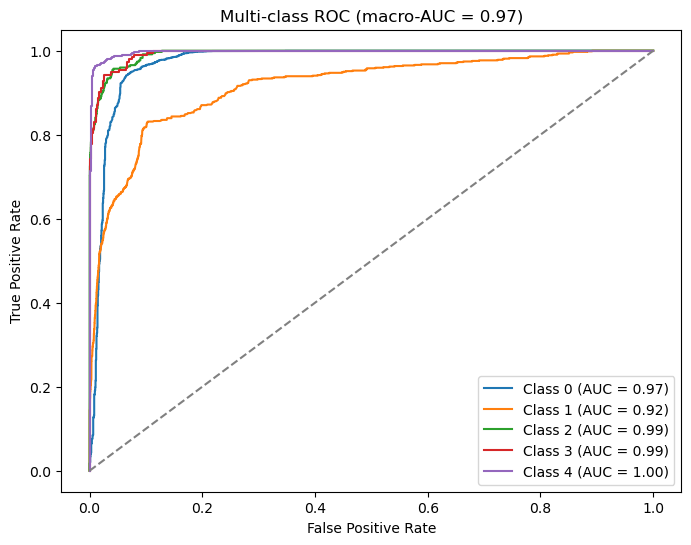

In [14]:
plt.figure(figsize = (8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle = "--", color = "grey")

plt.title(f"Multi-class ROC (macro-AUC = {roc_auc_macro:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Save Model

In [17]:
joblib.dump(best_model, open("./svm_tuned.joblib", 'wb'))

# Load Model

In [19]:
best_model_loaded = joblib.load(open("svm_tuned.joblib", 'rb'))
best_model_loaded.predict(f_test)

array([0, 0, 0, ..., 3, 0, 0], shape=(5868,))

# Other / Old

### k-Fold Cross Validation

The dataset is split into `k` folds (partitions). From `1` to `k`, a series of models is trained using `k-1` folds as training data; then tested on the remaining data.

In [12]:
"""
cv_scores = cross_val_score(pipeline, features, targets, cv = 3)
print(f"Mean Accuracy:\t{cv_scores.mean():0.4f}\nStDev:\t\t{cv_scores.std():0.4f}\n}")
"""

'\ncv_scores = cross_val_score(pipeline, features, targets, cv = 3)\nprint(f"Mean Accuracy:\t{cv_scores.mean():0.4f}\nStDev:\t\t{cv_scores.std():0.4f}\n}")\n'